---
# Module 3: Exemple de régression de données
---

<p>&nbsp;</p>
<div align="center">
    <img src= https://drive.google.com/uc?id=1QCpKyVyFrVJ9SWahPvCA1TT9IzelJ7u5  width="400" />
    <div>
    <font size="1.5">Image Source: https://www.spiegel.de/panorama/christie-s-erzherzog-diamant-fuer-21-5-millionen-dollar-versteigert-a-867063.html//</font>
    </div>
</div>
<p>&nbsp;</p>
 
 
Dans ce script en Python, nous allons montrer un exemple typique de régression d'un jeu de données provenant d'une base de données réelles sur des diamants. 

Nous allons voir les différentes étapes à réaliser avant d'entraîner un modèle de régresseur qui nous permettra d'évaluer le prix d'un diamant en fonction de caractéristiques mesurées par des gemmologues professionnels.

Nous allons utiliser un [régresseur linéaire](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) et un autre heuristique, [XGBoost](https://xgboost.readthedocs.io/en/latest/). Nous allons montrer comment traiter les variables catégorielles du jeu de données. Ce type de données très courant est plus difficile à gérer que les données numériques généralement rencontrées. 

La méthode systématique permettant d'optimiser un classificateur/régresseur, ou plusieurs en même temps, est expliquée dans un autre tutoriel de ce cours.


### Informations sur la base de données.

La base de données [Diamonds]( https://www.kaggle.com/shivam2503/diamonds?select=diamonds.csv) 
contient 10 variables continues et catégoriques qui ont été mesurées sur 53 940 diamants.

 
Liste des variables du jeu de données.

<ul>
<li><b>price</b>: prix en dollars US,</li>
<li><b>carat</b>: le poids en carats du diamant,</li>
<li><b>cut</b>: la qualité de la taille, de passable (<i>fair</i>), bonne (<i>good</i>), très bonne (<i>very good</i>), supérieure (<i>premium</i>), à idéale (<i>ideal</i>),</li>
<li><b>color</b>: couleur du diamant, de J (la pire) à D (la meilleure),</li>
<li><b>clarity</b>: clarté ou pureté du diamant, de I1 (la pire), SI2, SI1, VS2, VS1, VVS2, VVS1, à IF (la meilleure),</li>
<li><b>x</b>: longueur en mm, </li>
<li><b>y</b>: largeur en mm,</li>
<li><b>z</b>: hauteur en mm,</li>
<li><b>depth</b>: pourcentage de la profondeur = z / moyenne (x, y),</li>
<li><b>table</b>: largeur du sommet du diamant mesurée au point le plus large.</li>
</ul>
    
    

La figure suivante montre ce qu'est la profondeur (*depth*), à ne pas confondre avec la hauteur d'un diamant. Un diamant de même forme, mais 10x plus gros qu'un autre aurait une hauteur 10x plus grande, mais la même profondeur. Notez l'effet de la profondeur sur la luminosité, et donc la beauté, d'un diamant. Un diamant aplati ou étiré aurait une faible luminosité.

<p>&nbsp;</p>
<div align="center">
    <img src= https://drive.google.com/uc?id=1Dedu3h-ioz6xCpoTjdW2VettOpteed0g   width="400" />
    <div>
    <font size="1.5">Image Source: https://www.bloomingbeautyring.com/diamond-cuts//</font>
    </div>
</div>
<p>&nbsp;</p>

Ces variables sont-elles toutes essentielles pour déterminer le prix d'un diamant? C'est ce que nous allons voir dans ce script.


### Étapes de traitement des données
Dans ce qui suit, nous allons effectuer les étapes suivantes :
<ul>
<li>le traitement des valeurs manquantes,</li>
<li>le traitement des valeurs dupliquées,</li>
<li>le traitement des valeurs aberrantes,</li>
<li>l'élimination des variables inutiles,</li>
<li><b>le traitement des variables catégoriques.</b></li>
</ul>

L’ensemble du jeu de données sera utilisé pour effectuer cette analyse exploratoire.

### IMPORTANT: Copie du notebook!

Vous devez faire une copie du notebook sur votre ordinateur avant de l'exécuter, car les modifications dans le notebook original ne seront pas sauvegardées. Vous travaillerez ainsi dans la copie et non dans l'original.


Importation des fichiers à utiliser dans le tutoriel.

In [ ]:
%%bash
git clone https://github.com/Cours-EDUlib/IVADO-AA.git
mv IVADO-AA/module_3/* ./
rm -r IVADO-AA

Cloning into 'IVADO-AA'...
mv: cannot stat 'IVADO-AA/module_3/*': No such file or directory


In [ ]:
%%capture
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import LocalOutlierFactor
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)

%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Pour la reproductibilité des résultats
np.random.seed(43)

# Author: Pierre Gravel <pierre.gravel@iid.ulaval.ca>
# License: BSD

## Partie I: Prétraitement des données

#### Lecture des données

Les données sont écrites dans un dataframe. Ce type de structure organise les données en lignes et en colonnes, ce qui en fait une structure de données bidimensionnelle.

In [ ]:
df = pd.read_csv('diamonds.csv')

#### Affichage des 5 premières lignes du fichier.

In [ ]:
df.head(5)

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


On voit qu'il y a trois variables catégoriques (*cut*, *color*, *clarity*) ainsi qu'une variable servant d'indice (*Unnamed: 0*).

Élimination de la variable *Unnamed: 0*.

In [ ]:
df=df.drop(['Unnamed: 0'],axis=1)

### Identification des valeurs manquantes

Les valeurs manquantes dans les bases de données sont souvent indiquées par  NaN (<i>not a number</i>) 
ou par des zéros. 

#### Affichage du nombre de valeurs manquantes NaN dans le dataframe.


In [ ]:
df.isna().sum()

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64

Il n'y a aucune valeur de type NaN pour les variables mesurées.

#### Affichage des valeurs minimales pour chaque variable

Toutes les variables numériques étant positives, celles avec des valeurs minimales nulles peuvent révéler la présence de valeurs manquantes.

In [ ]:
df.min()

carat       0.2
cut        Fair
color         D
clarity      I1
depth      43.0
table      43.0
price       326
x           0.0
y           0.0
z           0.0
dtype: object

Les variables *x*, *y* et *z* ont des valeurs minimales de 0, ce qui est impossible, car ces valeurs sont les dimensions de diamants spécifiques. Combien y en a-t-il?

In [ ]:
n = len(df[(df['x']==0) | (df['y']==0) | (df['z']==0)])
p = round(100*n/df.shape[0],2)

print('Nombre de valeurs manquantes %d, fraction du nombre total %0.2f%%' % (n, p))

Nombre de valeurs manquantes 20, fraction du nombre total 0.04%


Ce nombre est négligeable. Éliminons ces données problématiques 

In [ ]:
df.drop(df[df['x']==0].index, inplace=True)
df.drop(df[df['y']==0].index, inplace=True)
df.drop(df[df['z']==0].index, inplace=True)

#### Élimination des valeurs dupliquées (doublons)

Dans une base de données contenant près de 54 000 entrées, il est probable qu'il y ait plusieurs valeurs répétées. Combien y en a-t-il?

In [ ]:
df_doublons = df[df.duplicated(keep='first')]

print('Nombre de valeurs dupliquées %d' % (len(df_doublons)))

Nombre de valeurs dupliquées 145


Éliminons ces données problématiques, sauf la première de chaque doublon.

In [ ]:
df = df.drop(df_doublons.index , axis=0)

#### Séparation des variables numériques

Sélectionnons les variables d'entrée numériques.

In [ ]:
features = ['carat', 'depth', 'table', 'x', 'y', 'z']
X = df[features]

### Transformation des variables

Examinons les distributions des variables d'entrée numériques.

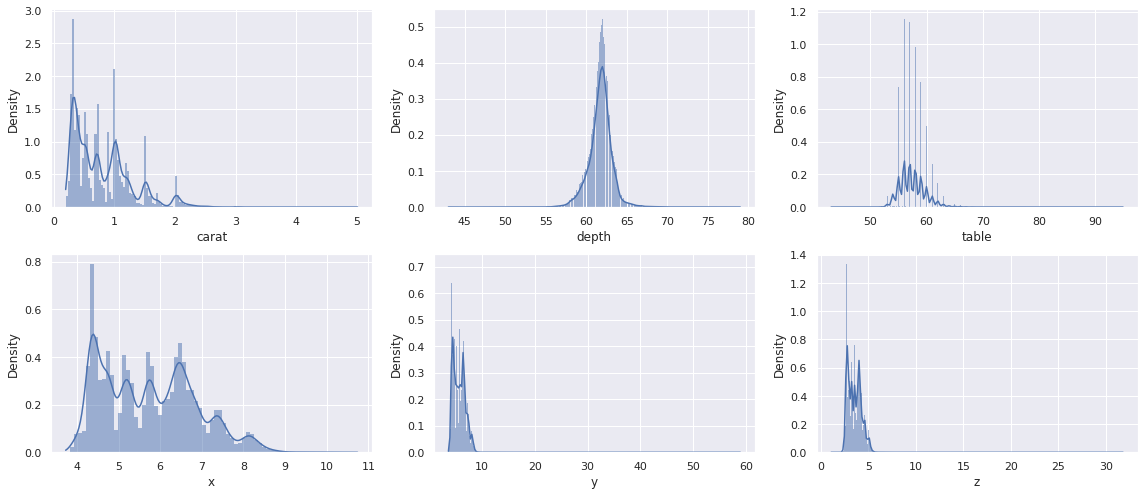

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(16, 7))
for ax, feature in zip(axes.flat, features):
    sns.histplot(df[feature], ax=ax, kde=True, stat="density", linewidth=0)
plt.tight_layout()

On voit qu'il y a beaucoup de structure dans les histogrammes; la plupart sont des distributions multimodales complexes. Aucune transformation de variables ne sera effectuée.

### Élimination des valeurs aberrantes (<i>outliers</i>)

La figure précédente révèle la présence de valeurs aberrantes; les plages étendues des variables sont plus larges que celles des distributions observées.

Nous n'allons pas utiliser de méthodes classiques basées sur l'hypothèse de normalité telle que l'[intervalle interquartile](https://en.wikipedia.org/wiki/Interquartile_range) pour localiser et éliminer les valeurs aberrantes. Ces méthodes traitent une variable à la fois en émettant l'hypothèse qu'elles sont indépendantes et unimodales. Ce n'est pas le cas ici.


#### Affichage des distributions conjointes des variables numériques

Ce type de diagramme met en valeur les corrélations multiples entre les variables ainsi que les valeurs aberrantes. 

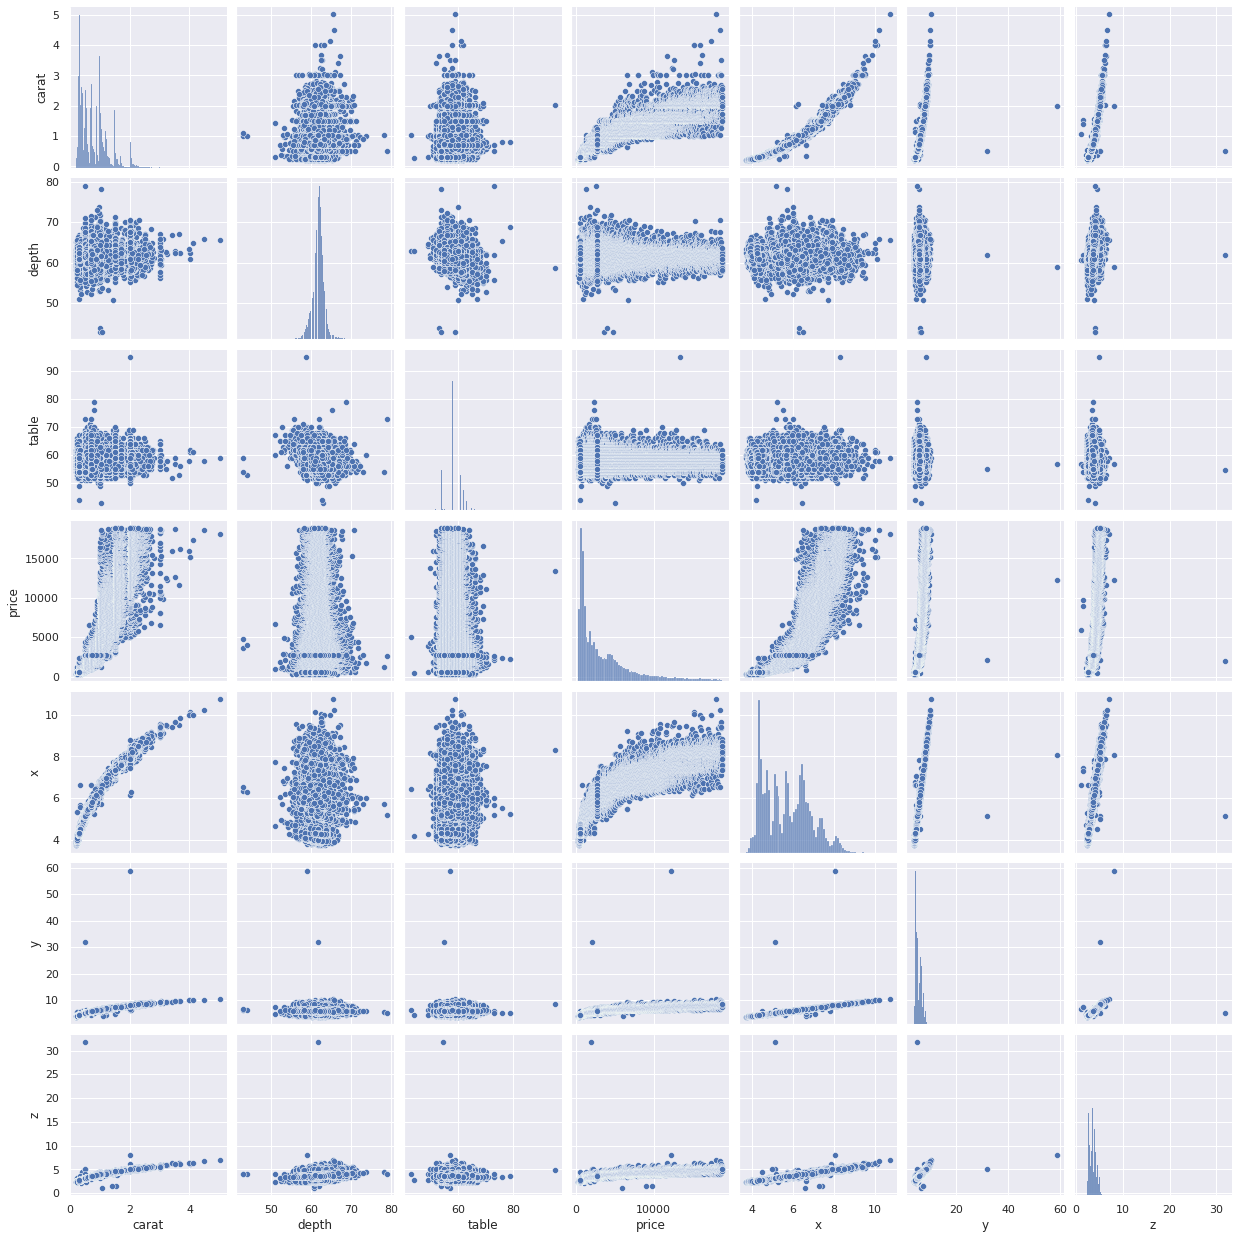

In [ ]:
sns.pairplot(df)

Plusieurs variables sont visiblement corrélées et les valeurs aberrantes sont facilement identifiables. Nous allons utiliser la méthode [Local Outlier Factor](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html) pour  identifier ces dernières et les éliminer.

N.B. La méthode LocalOutlierFactor mesure la distance entre les différents points dans l'espace des variables d'entrée. Comme on a vu précédemment, celles-ci varient sur différents ordres de grandeur. Il faut donc les normaliser. Cette normalisation est utilisée uniquement pour identifier les valeurs aberrantes. On retourne ensuite aux variables originales.

#### Élimination des valeurs aberrantes

In [ ]:
def elimine_valeurs_aberrantes(data, Xcol, n_neighbors=20):
    df2 = data.copy(deep=True)
    
    # Normalisation des variables d'entrées
    scaler = StandardScaler()
    df2[Xcol] = scaler.fit_transform(df2[Xcol])

    # Détection des valeurs aberrantes. Cette fonction ajoute une variable outliers 
    # dans le dataframe. La variable outliers vaut -1 pour les valeurs aberrantes 
    # et +1 pour les autres
    lof = LocalOutlierFactor(n_neighbors)
    df2['outliers'] = lof.fit_predict(df2[Xcol])
    
    # Élimination des valeurs aberrantes des données originales. 
    # On conserve ainsi les variables originales, sans normalisation.
    data.drop(df2[df2.outliers < 0].index, inplace = True)
    
    return data

In [ ]:
n_avant = df.shape[0]

df = elimine_valeurs_aberrantes(df, features, 20)

n_apres = df.shape[0]

print('Nombre de valeurs aberrantes éliminées : %d (%0.1f %%)' % (n_avant-n_apres, 100*(1-n_apres/n_avant)))

Nombre de valeurs aberrantes éliminées : 1063 (2.0 %)


#### Affichage des distributions conjointes des variables numériques après élimination des valeurs aberrantes

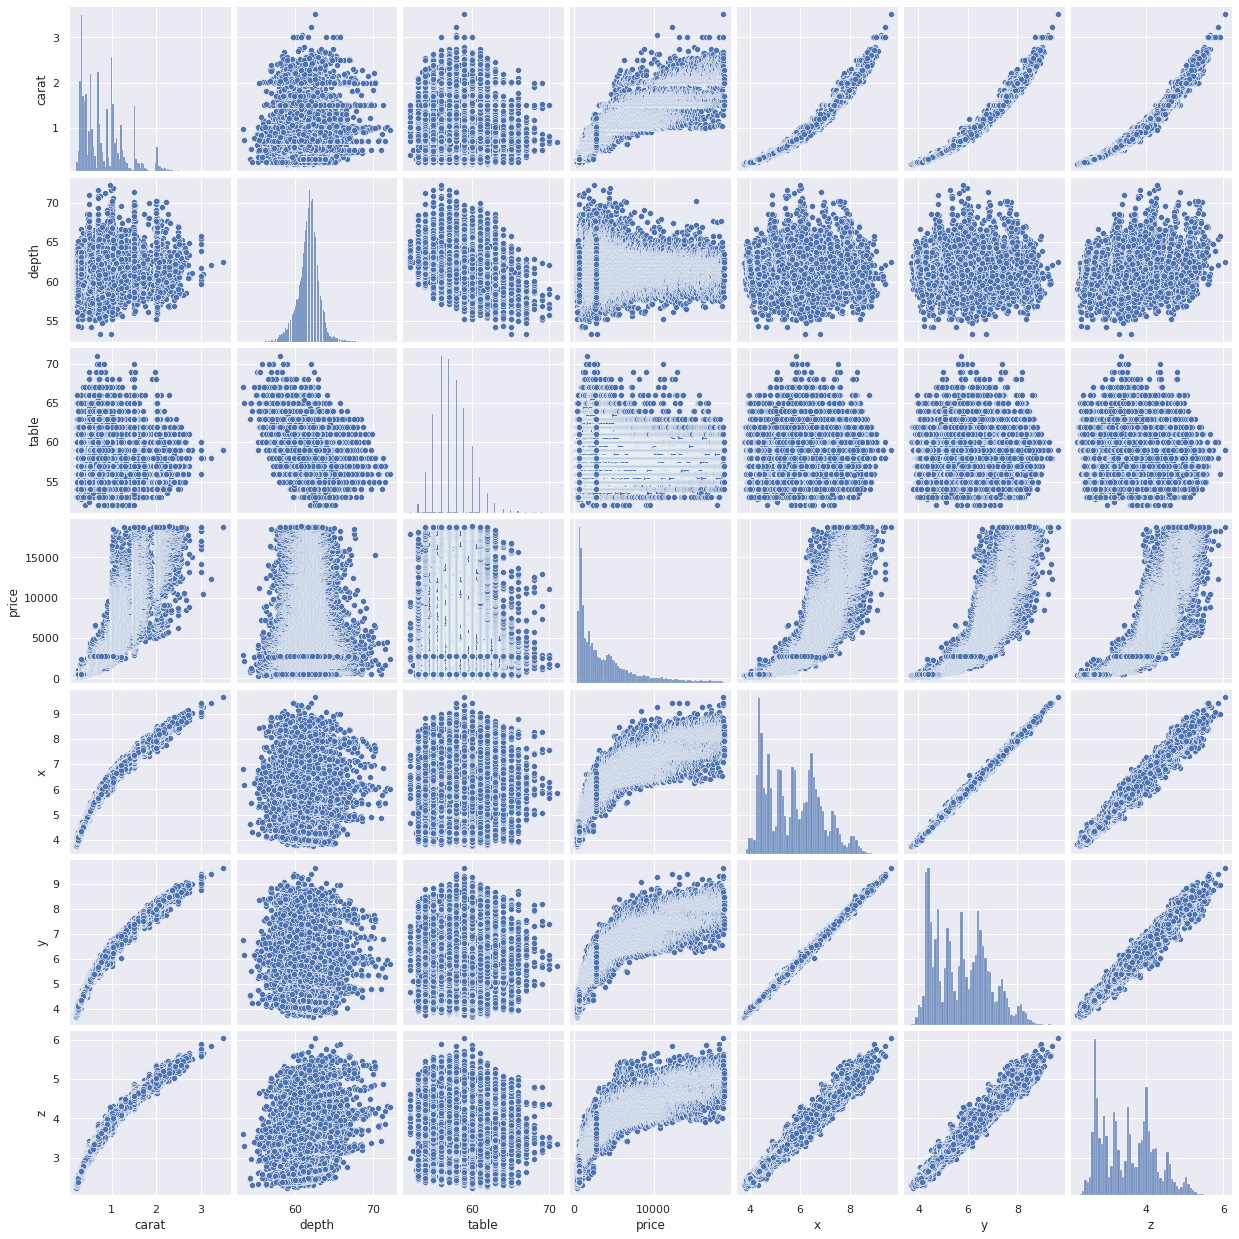

In [ ]:
sns.pairplot(df)

On remarque que les distributions le long de la diagonale principale ont maintenant des plages de valeurs limitées et sont plus détaillées. De plus, les relations linéaires et nonlinéaires entre certaines variables sont bien révélées. 

#### Calcul et affichage de la matrice de corrélation

Cette matrice est un bon outil pour détecter 

<ul>
<li>les entrées fortement corrélées entre elles,</li>
<li>la corrélation entre les variables d'entrées et la réponse à prédire.</li>
</ul>

<ipython-input-19-8b58c7dec224>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


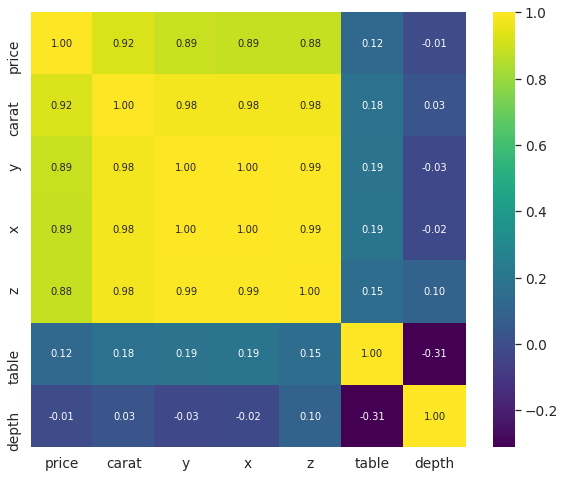

In [ ]:
# Calcul de la matrice de corrélation
corr = df.corr()

# Nombre de variables utilisées
nvar = len(df.columns)

plt.figure(figsize=(10, 8))
cols = corr.nlargest(nvar, 'price')['price'].index
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', 
                 annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values, cmap="viridis")
plt.show()

La première ligne de la matrice montre que le prix d'un diamant est fortement corrélé avec les dimensions *x*, *y* et *z* ainsi qu'avec son poids. Est-ce réellement surprenant? Elle montre aussi que la variable 'table' a peu d'impact sur le prix. La variable depth (pourcentage de la profondeur) n'en a aucun! Ce dernier point semble contre-intuitif puisqu'on a montré son importance sur la luminosité des diamants. Toutefois celle-ci varie de moins de 20% dans les données nettoyées. Elle est donc relativement constante et a peu d'effet sur le prix.

Les variables *x*, *y* et *z* sont fortement corrélées entre elles avec des corrélations entre 98 % et 100 %. On va quand même les conserver puisque ce ne sont pas tous les régresseurs qui sont sensibles aux variables corrélées.

**EXERCICE**: Dans la cellule suivante, enlevez les variables *y*, *z* et *depth*; les deux premières sont redondantes par rapport à *x* et la dernière n'a aucun effet sur le prix. Exécutez ensuite le reste du script afin de voir l'effet d'élimination de ces variables sur les performances du régresseur. Quelles conclusions en tirez-vous?

#### Élimination des variables inutiles

In [ ]:
df=df.drop(['depth'],axis=1)

### Traitement des variables catégoriques

Les variables *cut*, *color* et *clarity* sont ordinales. Il faut les transformer en valeurs numériques afin de les utiliser dans un régresseur.

<ul>
<li><b>cut</b>: la qualité de la taille, de passable (<i>fair</i>), bonne (<i>good</i>), très bonne (<i>very good</i>), supérieure (<i>premium</i>), à idéale (<i>ideal</i>),</li>
<li><b>color</b>: couleur du diamant, de J (la pire) à D (la meilleure),</li>
<li><b>clarity</b>: clarté ou pureté du diamant, de I1 (la pire), SI2, SI1, VS2, VS1, VVS2, VVS1, à IF (la meilleure).</li>
</ul>

Cette section est importante, car plusieurs méthodes de transformation sont utilisées dans la pratique, et souvent sans discernement. Les résultats d'entraînement peuvent varier grandement entre celles-ci.

<p>&nbsp;</p>
<div align="center">
    <img src= https://drive.google.com/uc?id=15JmBkZZ_TpbKPKDYp3-htJ9aBJQ1Wt3V  width="300" />
    <div>
    <font size="1.5">Image Source: http://clipart-library.com/professor-cliparts.html//</font>
    </div>
</div>
<p>&nbsp;</p>


#### Affichage des 5 premières lignes du dataframe avant transformation

In [ ]:
df.head()

,carat,cut,color,clarity,table,price,x,y,z
0,0.23,Ideal,E,SI2,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,58.0,335,4.34,4.35,2.75


#### Méthode I

C'est la plus simple. On laisse tomber les variables catégoriques afin de simplifier l'analyse.

Créons un dataframe ne contenant que les variables sauvegardées. Il contient cinq caractéristiques et une réponse.

In [ ]:
df1 = df.copy(deep=True)

df1 = df1.drop(['cut', 'color', 'clarity'],axis=1)

df1.head()

,carat,table,price,x,y,z
0,0.23,55.0,326,3.95,3.98,2.43
1,0.21,61.0,326,3.89,3.84,2.31
2,0.23,65.0,327,4.05,4.07,2.31
3,0.29,58.0,334,4.20,4.23,2.63
4,0.31,58.0,335,4.34,4.35,2.75


#### Méthode II

Cette méthode convertit les variables catégoriques ordinales en entiers croissants. Elle utilise une simple relation linéaire entre les niveaux de chaque variable. C'est plutôt arbitraire, mais conserve néanmoins l'ordre des valeurs ordinales.

Créons un dataframe ne contenant que les variables transformées. Il contient huit caractéristiques et une réponse.

In [ ]:
df2 = df.copy(deep=True)

df2['cut']=df2['cut'].map({'Fair':0, 'Good':1, 'Very Good':2, 'Premium':3, 'Ideal':4})
df2['color']=df2['color'].map({'J':6,'I':5,'H':4,'G':3,'F':2,'E':1,'D':0})
df2['clarity']=df2['clarity'].map({'I1':0, 'SI2':1, 'SI1':2, 'VS2':3, 'VS1':4, 'VVS2':5, 'VVS1':6, 'IF':7})

df2.head()

,carat,cut,color,clarity,table,price,x,y,z
0,0.23,4,1,1,55.0,326,3.95,3.98,2.43
1,0.21,3,1,2,61.0,326,3.89,3.84,2.31
2,0.23,1,1,4,65.0,327,4.05,4.07,2.31
3,0.29,3,5,3,58.0,334,4.20,4.23,2.63
4,0.31,1,6,1,58.0,335,4.34,4.35,2.75


#### Méthode III

Cette méthode convertit les variables catégoriques ordinales en variables factices (*dummy variables*). Chaque variable contenant N valeurs originales est convertie en N-1 variables binaires.  

Créons un dataframe ne contenant que les variables transformées. La fonction *get_dummies* ajoute le nom de chaque variable en préfixe aux variables binaires associées. Ça facilite leur identification. Le dataframe contient 22 caractéristiques et une réponse.

In [ ]:
df3 = df.copy(deep=True)

df3 = pd.get_dummies(df3, prefix={'cut':'cut', 'color':'color', 'clarity':'clarity'},
                          drop_first=True)

df3.head()

,carat,table,price,x,y,z,cut_Good,cut_Ideal,cut_Premium,cut_Very Good,...,color_H,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,0.23,55.0,326,3.95,3.98,2.43,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
1,0.21,61.0,326,3.89,3.84,2.31,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
2,0.23,65.0,327,4.05,4.07,2.31,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0.29,58.0,334,4.20,4.23,2.63,0,0,1,0,...,0,1,0,0,0,0,0,1,0,0
4,0.31,58.0,335,4.34,4.35,2.75,1,0,0,0,...,0,0,1,0,0,1,0,0,0,0


## Partie II: Entraînement de modèles

#### Définition d'une fonction permettant d'entraîner un régresseur avec un dataframe. 

La fonction effectue les tâches suivantes

<ul>
<li>séparation des données en ensembles d'entraînement et de test,</li>
<li>définition d'un pipeline implémentant une normalisation des entrées suivie d'une régression,</li>
<li>entraînement du pipeline,</li>
<li>calcul de la métrique de performance R2. Elle indique le pourcentage de la variance des données qui est expliquée par un modèle. Plus R2 est près de 100%, meilleure sont les prédictions du modèle </li>
</ul>

In [ ]:
def performances(méthode, data, reg):
    # Séparation des noms de variables en entrées et en sortie
    features = data.columns.to_list()
    Xcol = data.drop(['price'], axis=1).columns.to_list()
    Ycol = 'price'

    # Séparation des variables en entrées X et en sortie Y.
    X = data[Xcol]
    y = data[Ycol]

    # Séparation des données en ensembles d'entraînement (80 %) et de test (20 %).
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)

    # Définition d'un pipeline implémentant une normalisation des entrées suivie d'une régression
    ml_pipeline = Pipeline([
     ('std_scaler', StandardScaler()),
     ('regresseur', reg)
     ])

    # Entraînement du pipeline
    ml_pipeline.fit(X_train,y_train)

    y_pred = ml_pipeline.predict(X_test)
    
    # Calcul du score (métrique R2)
    r2_train = ml_pipeline.score(X_train, y_train)
    r2_test = ml_pipeline.score(X_test, y_test)

    print(méthode + 'R2 en train: %0.1f%%    R2 en test: %0.1f%%' % (round(100*r2_train,1), round(100*r2_test,1)))

    return ml_pipeline, y_test, y_pred

### Régresseur linéaire

Ce régresseur utilise une combinaison linéaire des variables d'entrée. C'est un modèle analytique. On peut y ajouter des interactions entre les variables, mais cela augmente le nombre de coefficients du modèle à déterminer. 

#### Entraînement du régresseur selon les trois méthodes

In [ ]:
pipeline1 = performances('Méthode I   : ', df1, LinearRegression())
pipeline2 = performances('Méthode II  : ', df2, LinearRegression())
pipeline3 = performances('Méthode III : ', df3, LinearRegression())

Méthode I   : R2 en train: 86.8%    R2 en test: 87.0%
Méthode II  : R2 en train: 91.4%    R2 en test: 91.7%
Méthode III : R2 en train: 92.5%    R2 en test: 92.7%


La méthode I est la moins performante des trois. L'élimination des variables catégoriques limite grandement les performances du modèle. La facilité est rarement la meilleure option.

La méthode II performe mieux même si l'ordonnancement linéaire des valeurs transformées est peu probable en réalité. 

La méthode III performe le mieux. C'est généralement le cas avec un régresseur linéaire. C'est pour cette raison qu'il est recommandé de transformer les variables catégoriques (ordinales ou nominales) en variables factices.


### Régresseur XGBoost

Ce régresseur utilise une approche heuristique basée sur des arbres de décision; ce n'est pas un modèle analytique. Il tient compte des interactions entre les variables d'entrée sans avoir à les spécifier explicitement.

#### Entraînement du régresseur selon les trois méthodes

In [ ]:
pipeline4 = performances('Méthode I   : ', df1, XGBRegressor(learning_rate=0.05))

pipeline5, y_test, y_pred = performances('Méthode II  : ', df2, XGBRegressor(learning_rate=0.05))

pipeline6 = performances('Méthode III : ', df3, XGBRegressor(learning_rate=0.05))

Méthode I   : R2 en train: 89.6%    R2 en test: 88.9%
Méthode II  : R2 en train: 98.5%    R2 en test: 98.3%
Méthode III : R2 en train: 97.2%    R2 en test: 96.9%


À nouveau, la méthode I est la moins performante des trois, pour les mêmes raisons que précédemment.

La méthode II performe le mieux! Elle modélise une fonction hautement nonlinéaire entre les variables d'entrée en 8-D et la réponse à prédire. 

La méthode III performe moins bien que la seconde. Les données d'entrées sont maintenant en 22-D au lieu de 8-D. La régression est moins précise.

### Comparaison des valeurs réelles et prédites pour le meilleur régresseur (#5)

Affichage des valeurs pour l'ensemble de test.

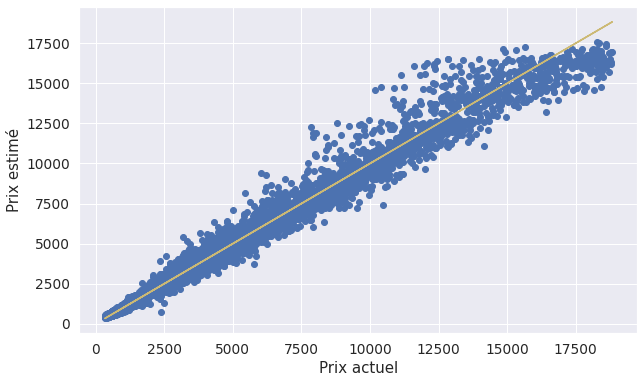

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(x = y_test, y = y_pred)
ax.plot(y_test, y_test, c='y')
plt.xlabel("Prix actuel")
plt.ylabel("Prix estimé")

plt.show()

On voit que les prévisions du modèle XGBoost sont relativement bonnes pour les diamants valant moins de 15 000 USD, soit la très grande majorité des diamants utilisés dans l'analyse (environ 98%). Le modèle explique 98% de la variabilité des données.

### Faire une prédiction pour un diamant à la fois

Beaucoup d'exemples sur le web montrent comment optimiser les performances d'un régresseur ou de plusieurs en même temps afin de sélectionner le meilleur d'entre eux. Toutefois, ils ne montrent presque jamais comment utiliser ensuite ce régresseur sur de nouvelles données.

<p>&nbsp;</p>
<div align="center">
    <img src= https://drive.google.com/uc?id=1fB5l-x53l4JJmsubt265VI-iKWIbNUJB  width="400" />
        <div>
    <font size="1.5">Image Source: https://handsjewelers.com/the-4cs-of-diamond-quality//</font>
    </div>
</div>
<p>&nbsp;</p>

La cellule suivante montre un exemple d'utilisation avec les données pour un diamant à évaluer.

In [ ]:
df = pd.DataFrame({    
    'carat' : 0.75,
    'cut' : 'Ideal', 
    'color' : 'H', 
    'clarity' : 'VVS1', 
    'depth' : 61.0,
    'table' : 60.0, 
    'x' : 5.7,
    'y' : 6.0,
    'z' : 3.6}, index=[0])


# Élimination des variables inutiles ou redondantes (prétraitement)
df=df.drop(['depth'],axis=1)
    
# Transformation des variables ordinales (prétraitement, méthode II)
df['cut']=df['cut'].map({'Fair':0, 'Good':1, 'Very Good':2, 'Premium':3, 'Ideal':4})
df['color']=df['color'].map({'J':6,'I':5,'H':4,'G':3,'F':2,'E':1,'D':0})
df['clarity']=df['clarity'].map({'I1':0, 'SI2':1, 'SI1':2, 'VS2':3, 'VS1':4, 'VVS2':5, 'VVS1':6, 'IF':7})
    
prix = pipeline5.predict(df)

print('Prix du diamant: %0.2f USD' % (prix))

Prix du diamant: 3569.37 USD
